In [179]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as pl
import sys, os
sys.path.append('../')
from binacox import get_m_1, get_m_2
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Compute metrics

In [180]:
n_features = 50
rslt_dir = "./results_data/p_%s/" % n_features
methods = ["binacox", "auto_cutoff_bonferroni", "auto_cutoff_laus_schu"]
alpha = .05
start = False
for n_cut_points in [1, 2, 3]:
    for method in methods: 
        method_ = method if method == "binacox" else "auto_cutoff"
        rslt = pd.read_json(rslt_dir + "results_%s_n_cut_points_%s" % (method_, n_cut_points))
        n_samples_grid = list(np.sort(rslt.n_samples.unique()))
        if not start:
            results_m1 = pd.DataFrame(columns=["method", "n_cut_points"] + n_samples_grid)
            results_m2 = pd.DataFrame(columns=["method"] + n_samples_grid)
            start = True
        m1_data, m2_data = pd.DataFrame(), pd.DataFrame()
        for n in n_samples_grid:    
            rslt_n = rslt[rslt.n_samples == n]
            m1_n, m2_n = [], []
            for simu_idx in rslt_n.index:
                cut_points = rslt_n.cut_points[simu_idx]
                cut_points_estimates = rslt_n.cut_points_estimates[simu_idx]
                S = rslt_n.S[simu_idx]
                if method != "binacox":
                    p_values_corr = rslt_n.p_values_corr[simu_idx]
                    p_values_min = rslt_n.p_values_min[simu_idx]
                    n_tested = rslt_n.n_tested[simu_idx]     
                    if method == "auto_cutoff_bonferroni":
                        idx_nan = []
                        for i in range(len(p_values_min)):
                            if p_values_min[i] > alpha / n_tested[i]:
                                idx_nan += [i]
                    if method == "auto_cutoff_laus_schu":
                        idx_nan = np.where(np.array(p_values_corr) > alpha)[0]
                    cut_points_estimates = np.array(cut_points_estimates)
                    cut_points_estimates[idx_nan] = np.nan
                    cut_points_estimates_ac = {}
                    for j in range(len(cut_points_estimates)):
                        est_j = [None, None]
                        if cut_points_estimates[j] == cut_points_estimates[j]:
                            est_j.insert(1, cut_points_estimates[j])
                        cut_points_estimates_ac[str(j)] = est_j
                    cut_points_estimates = cut_points_estimates_ac 
                hat_K_star, K_star = np.array([]), np.array([])
                for j in range(len(cut_points_estimates)):
                    hat_K_star = np.append(hat_K_star, len(cut_points_estimates[str(j)]) - 2)
                    K_star_j = 0 if j in S else len(cut_points[str(j)]) - 2
                    K_star = np.append(K_star, K_star_j)
                m1_n += [get_m_1(cut_points_estimates, cut_points, S)]                
                m2_n += [get_m_2(hat_K_star, S)]
            m1_data[n], m2_data[n] = m1_n, m2_n
        m1_data["method"] = method
        m1_data["n_cut_points"] = n_cut_points
        results_m1 = results_m1.append(m1_data, ignore_index=True)
        if n_cut_points == 1:
            m2_data["method"] = method
            results_m2 = results_m2.append(m2_data, ignore_index=True)

## Plot results

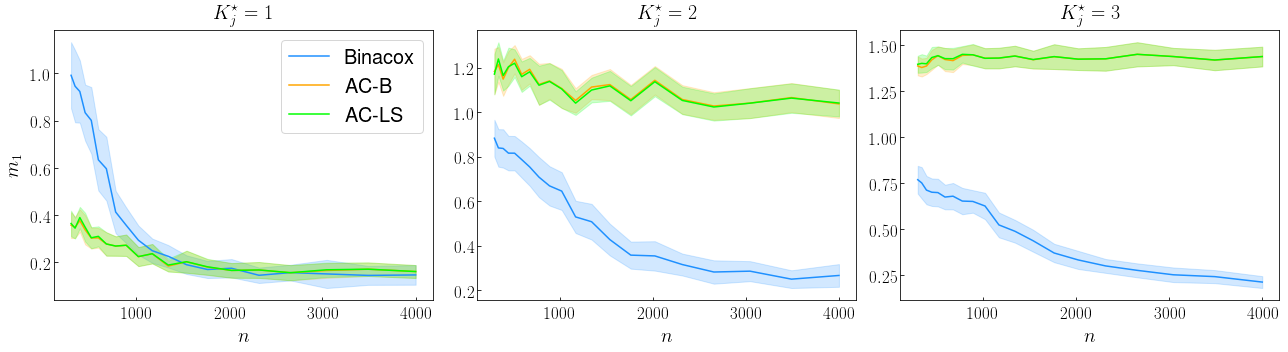

In [184]:
fig = pl.figure(figsize=(18, 5))
method_color = ["dodgerblue", "orange", "lime"]
methods_label = {'binacox': 'Binacox', 
                 'auto_cutoff_bonferroni': 'AC-B', 
                 'auto_cutoff_laus_schu': 'AC-LS'}

for idx_method, method in enumerate(methods):
    for n_cut_points in [1, 2, 3]:
        ax = fig.add_subplot(1, 3, n_cut_points)
        data = results_m1[(results_m1.method == method) &
                          (results_m1.n_cut_points == n_cut_points)]
        data.drop(["method", "n_cut_points"], axis=1, inplace=True)
        mean = data.mean()
        eps = data.std() / np.sqrt(len(n_samples_grid)) * 1.96
        pl.plot(n_samples_grid, mean, color=method_color[idx_method], 
                label=methods_label[method])
        pl.fill_between(n_samples_grid, mean - eps, mean + eps, 
                        color=method_color[idx_method], alpha=0.2)            
        ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
        ax.set_xlabel('$n$', fontsize=20)
        if n_cut_points == 1:
            ax.set_ylabel('$m_1$', fontsize=20)
            pl.legend(prop={'size': 20})   
        pl.title(r"$K^\star_j=%s$" % n_cut_points, fontsize=20)
pl.tight_layout()
directory = "./figures/p_%s" % n_features
try:
    os.stat(directory)
except:
    os.mkdir(directory)
pl.savefig(directory + '/m_1.pdf', bbox_inches='tight')
pl.show()

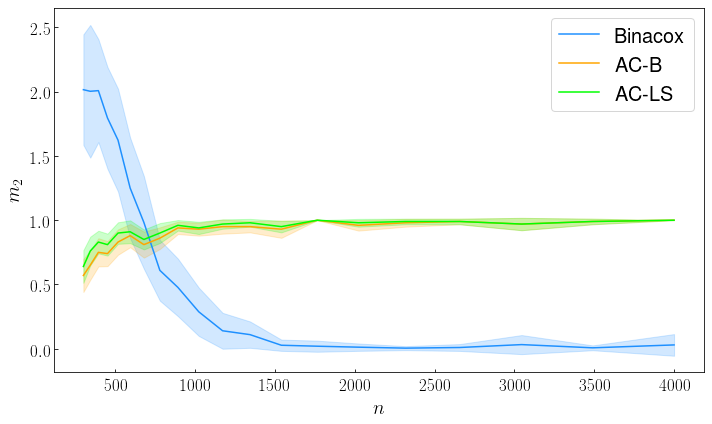

In [185]:
fig = pl.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for idx_method, method in enumerate(methods):
    data = results_m2[results_m2.method == method]
    data.drop(["method"], axis=1, inplace=True)
    mean = data.mean()
    eps = data.std() / np.sqrt(len(n_samples_grid)) * 1.96
    pl.plot(n_samples_grid, mean, color=method_color[idx_method], 
            label=methods_label[method])
    pl.fill_between(n_samples_grid, mean - eps, mean + eps, 
                    color=method_color[idx_method], alpha=0.2)            
ax.tick_params(axis='both', which='major', direction='in', labelsize=17)
ax.set_xlabel('$n$', fontsize=20)
ax.set_ylabel('$m_2$', fontsize=20)
pl.legend(prop={'size': 20})   
pl.tight_layout()
pl.savefig(directory + '/m_2.pdf', bbox_inches='tight')
pl.show()